# Criação do Modelo de Regressão

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from skopt import dummy_minimize

# Importando datasets

Serão testados 2 modelos com duas abordagens diferentes:
- Dataset sem valores nulos
- Dataset dropando as linhas que possuem valores nulos

In [2]:
df = pd.read_csv('casas_ponta_grossa.csv')       # Não existem valores nulos
df_na = pd.read_csv('casas_ponta_grossa_NA.csv') # Vários valores nulos que serão dropados

## Dataset dropando valores nulos:

In [3]:
df_na.dropna(inplace=True)

In [4]:
df_na.reset_index(drop=True, inplace=True)

In [5]:
df_na.shape

(1681, 8)

## Transformação de variáveis categóricas usando LabelEncoder

Variável Bairro, será transformada em valor numério usando Label encoder

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
label_encoder = LabelEncoder()

In [8]:
df['Bairro'] = label_encoder.fit_transform(df['Bairro'])
df_na['Bairro'] = label_encoder.fit_transform(df_na['Bairro'])

In [9]:
# Normalizando dados do LabelEncoder

mean = df['Bairro'].mean()
std = df['Bairro'].std()
df['Bairro'] = (df['Bairro'] - mean) / std

mean = df_na['Bairro'].mean()
std = df_na['Bairro'].std()
df_na['Bairro'] = (df_na['Bairro'] - mean) / std

## Separando variáveis alvos 

A variável alvo do modelo será o Valor de Venda do imóvel. 

In [10]:
y = df['Valor Venda']
y_na = df_na['Valor Venda']

## Removendo colunas

In [11]:
df.drop(columns='Valor Venda', inplace=True)
df.drop(columns='Referência', inplace=True)
df_na.drop(columns='Valor Venda', inplace=True)
df_na.drop(columns='Referência', inplace=True)

## Separando dados em treinamento e teste

In [12]:
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(df, y, test_size=0.3)
X_treinamento_na, X_teste_na, y_treinamento_na, y_teste_na = train_test_split(df_na, y_na, test_size=0.3)

# Criação do Modelo

## 1 - Modelo Base (Random Forest)

In [13]:
rf = RandomForestRegressor(n_estimators=1000, random_state=0, min_samples_leaf=1,  n_jobs=6)
rf_na = RandomForestRegressor(n_estimators=1000, random_state=0, min_samples_leaf=1,  n_jobs=6)

In [14]:
rf.fit(X_treinamento, y_treinamento)
rf_na.fit(X_treinamento_na, y_treinamento_na)

RandomForestRegressor(n_estimators=1000, n_jobs=6, random_state=0)

# Métricas de Avaliação

### Métrica Primária: MedAE - Median Absolute Error

Preço de casas na Zillow - https://www.zillow.com/research/putting-accuracy-in-context-3255/
 
### Métrica Secundária: (R)MSLE - (Root) Mean Squared Logarithmic Error - Raiz Quadrada do Erro Médio Logarítmico Quadrado

Se importa com a diferença "relativa" dos valores

In [15]:
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error

In [16]:
p = rf.predict(X_teste)
p_na =  rf_na.predict(X_teste_na)

In [17]:
medae = median_absolute_error(y_teste, p)
medae_na = median_absolute_error(y_teste_na, p_na)

msle = mean_squared_log_error(y_teste, p)
msle_na = mean_squared_log_error(y_teste_na, p_na)

print('MedAE:',round(medae,2))
print('MedAE drop NA:',round(medae_na,2))

print('MSLE:',round(msle,2))
print('MSLE drop NA:',round(msle_na,2))

MedAE: 99591.71
MedAE drop NA: 85913.0
MSLE: 0.22
MSLE drop NA: 0.15


## 2 - Modelo LightGBM

In [18]:
lgbm = lgb.LGBMRegressor(random_state=0)

LightGBM não aceita caracteres non-ASCII no nome das colunas, então temos que mudar o nome das colunas dos datasets

In [19]:
import re
X_teste = X_teste.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_teste_na = X_teste_na.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_treinamento = X_treinamento.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_treinamento_na = X_treinamento_na.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [20]:
lgbm = lgbm.fit(X_treinamento, y_treinamento)
lgbm_na = lgbm.fit(X_treinamento_na, y_treinamento_na)

In [21]:
p = lgbm.predict(X_teste)
p_na =  lgbm_na.predict(X_teste_na)

In [22]:
medae = median_absolute_error(y_teste, p)
medae_na = median_absolute_error(y_teste_na, p_na)

msle = mean_squared_log_error(y_teste, p)
msle_na = mean_squared_log_error(y_teste_na, p_na)

print('MedAE:',round(medae,2))
print('MedAE drop NA:',round(medae_na,2))

print('MSLE:',round(msle,2))
print('MSLE drop NA:',round(msle_na,2))

MedAE: 83958.24
MedAE drop NA: 83443.92
MSLE: 0.19
MSLE drop NA: 0.16


## Resultados Preliminares:

+ Random Forest:

 + MedAE: 99591.71    
 + MedAE drop NA: 85913.0    
 + MSLE: 0.22  
 + MSLE drop NA: 0.15   
  
  
+ LightGBM:

 + MedAE: 83958.24 
 + MedAE drop NA: 83443.92 
 + MSLE: 0.19  
 + MSLE drop NA: 0.16 
 
Podemos perceber que os modelos que foram treinados usando o dataset com os NA dropados obtiveram melhor score.  
Na parte seguinte utilizaremos somente o dataset com os NA dropados

# Tunando HiperParâmetros

## Random Search:

In [23]:
def treinar_modelo(parametros):
    
    learning_rate = parametros[0]
    num_leaves = parametros[1]
    min_child_samples = parametros[2]
    subsample = parametros[3]
    colsample_bytree = parametros[4]
    
    print(parametros)
    
    mdl = lgb.LGBMRegressor(learning_rate=learning_rate, num_leaves=num_leaves, 
                            min_child_samples=min_child_samples, subsample=subsample, 
                            colsample_bytree=colsample_bytree, random_state=0, 
                            subsample_freq=1, n_estimatos=100)
    mdl.fit(X_treinamento_na, y_treinamento_na)
    
    p = mdl.predict(X_teste_na)
    
    return median_absolute_error(y_teste_na, p)   
    
    

In [24]:
espaco_de_treinamento = [(1e-9, 1e-1, 'log-uniform'), 
                         (2, 256),
                         (1, 100),
                         (0.05, 1.0),
                         (0.1, 1.0)]

In [25]:
resultado = dummy_minimize(treinar_modelo, espaco_de_treinamento, random_state=1, verbose=1, n_calls=50)

Iteration No: 1 started. Evaluating function at random point.
[0.09494639669696242, 74, 10, 0.3372159440002478, 0.23208030173540176]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1197
Function value obtained: 90544.0699
Current minimum: 90544.0699
Iteration No: 2 started. Evaluating function at random point.
[5.479094086332446e-09, 206, 72, 0.3782826906908954, 0.457090726807603]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0459
Function value obtained: 356224.5744
Current minimum: 90544.0699
Iteration No: 3 started. Evaluating function at random point.
[2.044249367384062e-05, 256, 19, 0.5483207515942279, 0.49910760440160107]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1267
Function value obtained: 355800.5785
Current minimum: 90544.0699
Iteration No: 4 started. Evaluating function at random point.
[6.864639102632861e-08, 144, 51, 0.9182639233502714, 0.5114843271882895]
Iteration No: 4 ended. Evaluation done at r

In [26]:
resultado.x

[0.03909584151509792, 254, 15, 0.5788205287853987, 0.9240457147896471]

### Análise do Resultado:
Com os parâmetros:

learning_rate = 0.03909584151509792  
num_leaves = 254  
min_child_samples = 15  
subsample = 0.5788205287853987  
colsample_bytree = 0.9240457147896471

Temos que nossa métrica principal(MedAE) foi de 77290.0112


## Bayesian Optimization:

In [27]:
from skopt import gp_minimize

In [28]:
resultado_bayesian = gp_minimize(treinar_modelo, espaco_de_treinamento, random_state=1, verbose=1, n_calls=50, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[0.09494639669696242, 239, 14, 0.9990884895579377, 0.3124800792567785]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1476
Function value obtained: 87977.9001
Current minimum: 87977.9001
Iteration No: 2 started. Evaluating function at random point.
[1.488146949236865e-06, 101, 67, 0.9387621172657304, 0.8616798250174156]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0678
Function value obtained: 356193.2319
Current minimum: 87977.9001
Iteration No: 3 started. Evaluating function at random point.
[3.2076585745369137e-07, 135, 45, 0.2680983530433343, 0.5809725180523154]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0469
Function value obtained: 356223.8836
Current minimum: 87977.9001
Iteration No: 4 started. Evaluating function at random point.
[0.02049727824731352, 118, 44, 0.9421713999524447, 0.8005503127028804]
Iteration No: 4 ended. Evaluation done at ra

C:\Users\Victor\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 1.3640
Function value obtained: 81763.4696
Current minimum: 75376.3659
Iteration No: 25 started. Searching for the next optimal point.
[0.06153633059295451, 182, 1, 1.0, 1.0]
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 1.0507
Function value obtained: 79632.4002
Current minimum: 75376.3659
Iteration No: 26 started. Searching for the next optimal point.
[0.1, 256, 1, 0.7315188737268884, 1.0]
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 1.3406
Function value obtained: 81722.8570
Current minimum: 75376.3659
Iteration No: 27 started. Searching for the next optimal point.
[0.06185759587591597, 218, 1, 1.0, 1.0]
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.2367
Function value obtained: 77440.9265
Current minimum: 75376.3659
Iteration No: 28 started. Searching for the next optimal point.
[0.1, 256, 1, 0.69161

C:\Users\Victor\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 1.4726
Function value obtained: 81763.4696
Current minimum: 75376.3659
Iteration No: 35 started. Searching for the next optimal point.
[0.06506008044798631, 2, 1, 1.0, 1.0]
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 0.5984
Function value obtained: 117483.1898
Current minimum: 75376.3659
Iteration No: 36 started. Searching for the next optimal point.
[0.1, 256, 1, 0.6637905628074865, 1.0]
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 1.5268
Function value obtained: 87636.3902
Current minimum: 75376.3659
Iteration No: 37 started. Searching for the next optimal point.
[0.1, 256, 1, 1.0, 1.0]


C:\Users\Victor\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 1.6517
Function value obtained: 81763.4696
Current minimum: 75376.3659
Iteration No: 38 started. Searching for the next optimal point.
[0.0583556619892153, 256, 1, 1.0, 1.0]
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 1.6173
Function value obtained: 86939.6912
Current minimum: 75376.3659
Iteration No: 39 started. Searching for the next optimal point.
[0.1, 256, 1, 0.6935594744248024, 1.0]
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 1.6736
Function value obtained: 75645.6987
Current minimum: 75376.3659
Iteration No: 40 started. Searching for the next optimal point.
[0.1, 256, 1, 0.6663941225085838, 1.0]
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 1.5649
Function value obtained: 84024.2133
Current minimum: 75376.3659
Iteration No: 41 started. Searching for the next optimal point.
[0.1, 256, 1, 0.6918011

C:\Users\Victor\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.7543
Function value obtained: 81763.4696
Current minimum: 75376.3659
Iteration No: 46 started. Searching for the next optimal point.
[0.1, 256, 1, 1.0, 1.0]


C:\Users\Victor\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 1.7539
Function value obtained: 81763.4696
Current minimum: 75376.3659
Iteration No: 47 started. Searching for the next optimal point.
[0.06174362024647415, 256, 1, 1.0, 1.0]
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 1.7220
Function value obtained: 79498.7532
Current minimum: 75376.3659
Iteration No: 48 started. Searching for the next optimal point.
[0.1, 256, 1, 1.0, 1.0]


C:\Users\Victor\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 1.7902
Function value obtained: 81763.4696
Current minimum: 75376.3659
Iteration No: 49 started. Searching for the next optimal point.
[0.06508842228016615, 256, 1, 0.9920497868264317, 0.1402589168927174]
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 1.3459
Function value obtained: 91787.4542
Current minimum: 75376.3659
Iteration No: 50 started. Searching for the next optimal point.
[0.1, 256, 1, 1.0, 1.0]


C:\Users\Victor\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 1.8650
Function value obtained: 81763.4696
Current minimum: 75376.3659


In [29]:
resultado_bayesian.x

[0.1, 57, 1, 0.7268542296882123, 1.0]

### Análise do Resultado:
Com os parâmetros:

learning_rate = 0.1
num_leaves = 57 
min_child_samples = 1  
subsample = 0.7268542296882123 
colsample_bytree = 1.0  

Temos que nossa métrica principal(MedAE) foi de 75376.3659 

## Analisando as duas otimizações

In [30]:
from skopt.plots import plot_convergence

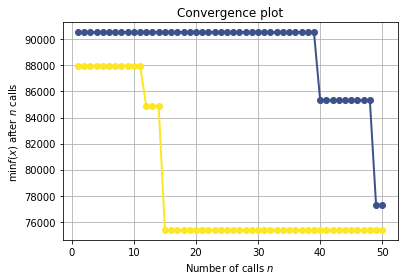

In [31]:
plot_convergence(resultado, resultado_bayesian)

## Treinando Modelo Final

In [33]:
def treinar_modelo_final(parametros):
    
    learning_rate = parametros[0]
    num_leaves = parametros[1]
    min_child_samples = parametros[2]
    subsample = parametros[3]
    colsample_bytree = parametros[4]
    
    
    mdl = lgb.LGBMRegressor(learning_rate=learning_rate, num_leaves=num_leaves, 
                            min_child_samples=min_child_samples, subsample=subsample, 
                            colsample_bytree=colsample_bytree, random_state=0, 
                            subsample_freq=1, n_estimatos=100)
    mdl.fit(X_treinamento_na, y_treinamento_na)
    
    return mdl

In [34]:
modelo_final = treinar_modelo_final(resultado_bayesian.x)

In [38]:
p_na_final = modelo_final.predict(X_teste_na)

In [41]:
medae_na = median_absolute_error(y_teste_na, p_na_final)
msle_na = mean_squared_log_error(y_teste_na, p_na_final)

print('MedAE drop NA:',round(medae_na,2))
print('MSLE drop NA:',round(msle_na,2))

MedAE drop NA: 75376.37
MSLE drop NA: 0.15


## Salvando Modelo

In [42]:
import joblib as jb

In [43]:
jb.dump(modelo_final, 'lightGBM.pkl.z')

['lightGBM.pkl.z']